In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Datasets

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X) # == tf.data.Dataset.range(10)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### Transformations

In [4]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [5]:
dataset = dataset.map(lambda x: 2*x, num_parallel_calls=2)
dataset = dataset.apply(tf.data.Dataset.unbatch) # == dataset.unbatch()
dataset = dataset.filter(lambda x: x < 10)

In [6]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Shuffling

In [7]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)

for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


##### Multiple Files

**Data example**

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

**Pipeline**

In [9]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [10]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers,
    num_parallel_calls=2
)

In [11]:
for line in dataset.take(5):
    print(line.numpy())

b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'


### Preprocessing Data

In [12]:
n_inputs = 8

@tf.function
def preprocess(line):
    defs = [0.0] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [13]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### My pipeline

In [14]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads
    )
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1) # Always will be one batch ahead

## Using Datasets

In [15]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.6396 - val_loss: 0.9007
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.7167 - val_loss: 0.6812
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6300 - val_loss: 0.6103
Epoch 4/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5921 - val_loss: 0.5622
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5875 - val_loss: 0.5674
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5506 - val_loss: 0.5200
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5148 - val_loss: 0.5303
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5049 - val_loss: 0.4819
Epoch 9/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5054 - val_loss: 0.4695
Epoch 10/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4853 - val_loss: 0.4609

In [17]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 2ms/step - loss: 0.4779


0.47788968682289124

# TFRecord Format

In [18]:
# Write
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_data.tfrecord', options) as f:
    f.write(b'Hello, world')
    f.write(b'Hello, world 2')

# Read
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths, compression_type='GZIP')

# Show
for item in dataset:
    print(item)

tf.Tensor(b'Hello, world', shape=(), dtype=string)
tf.Tensor(b'Hello, world 2', shape=(), dtype=string)


## Tensorflow Protobufs

### Example()

In [19]:
from tensorflow.train import (
    BytesList, FloatList, Int64List,
    Feature, Features, Example
)

person_example = Example(
    features=Features(
        feature={
            'name': Feature(bytes_list=BytesList(value=[b'Alice'])),
            'id': Feature(int64_list=Int64List(value=[123])),
            'emails': Feature(bytes_list=BytesList(value=[b'a@a.com', b'b@b.com']))
        }
    )
)

s = person_example.SerializeToString()
print(s)
person_2 = Example()
person_2.ParseFromString(s)
print(person_2 == person_example)

b'\n@\n\x0b\n\x02id\x12\x05\x1a\x03\n\x01{\n\x1e\n\x06emails\x12\x14\n\x12\n\x07a@a.com\n\x07b@b.com\n\x11\n\x04name\x12\t\n\x07\n\x05Alice'
True


In [20]:
# Write Serialized to TF Record
with tf.io.TFRecordWriter('my_contacts.tfrecord') as f:
    f.write(person_example.SerializeToString())

# Read record
features_description = {
    'name': tf.io.FixedLenFeature([], tf.string, default_value=""),
    'id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'emails': tf.io.VarLenFeature(tf.string)
}
for serialized_example in tf.data.TFRecordDataset(['my_contacts.tfrecord']):
    parsed_example = tf.io.parse_single_example(
        serialized_example,
        features_description
    )
    print(parsed_example, parsed_example['emails'].values)

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb8b69c2978>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>} tf.Tensor([b'a@a.com' b'b@b.com'], shape=(2,), dtype=string)


In [21]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b'')

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@a.com', b'b@b.com'], dtype=object)>

### SequenceExample()

In [22]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})
content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(
        bytes_list=BytesList(
            value=[word.encode('utf-8') for word in words]
        )
    )

content_featues = list(map(words_to_feature, content))
comments_featues = list(map(words_to_feature, comments))

sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(
        feature_list={
            'content': FeatureList(feature=content_featues),
            'comments': FeatureList(feature=comments_featues)
        }
    )
)

In [23]:
serialized_sequence_example = sequence_example.SerializeToString()

context_feature_descriptions = {
    'author_id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'title': tf.io.VarLenFeature(tf.string),
    'pub_date': tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0])
}
sequence_feature_descriptions = {
    'content': tf.io.VarLenFeature(tf.string),
    'comments': tf.io.VarLenFeature(tf.string)
}

parsed_context = tf.io.parse_single_sequence_example(
    serialized_sequence_example,
    context_feature_descriptions,
    sequence_feature_descriptions
)

parsed_context

({'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
  'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>,
  'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb8b69518d0>},
 {'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb8b6951940>,
  'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb8b6951978>})

In [24]:
tf.RaggedTensor.from_sparse(parsed_context[1]['content'])

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>

# Preprocessing Features

In [25]:
import os
import tarfile
import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## One-Hot encoding

In [26]:
# Get table
vocab = list(housing['ocean_proximity'].unique())
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2 # Possible unknown categories that will come next
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

# Use table
categories = tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'ISLAND'])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 5, 2, 4])>

In [27]:
cat_one_hot = tf.one_hot(cat_indices, depth=len(vocab) + num_oov_buckets)
cat_one_hot

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

## Embeddings

In [28]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.7413678 , 0.62854624],
       [0.01738465, 0.3431449 ],
       [0.51063764, 0.3777541 ],
       [0.07321596, 0.02137029],
       [0.2871771 , 0.4710616 ],
       [0.6936141 , 0.07321334],
       [0.93251204, 0.20843053]], dtype=float32)>

In [29]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.7413678 , 0.62854624],
       [0.6936141 , 0.07321334],
       [0.51063764, 0.3777541 ],
       [0.2871771 , 0.4710616 ]], dtype=float32)>

In [30]:
embedding = keras.layers.Embedding(
    input_dim=len(vocab) + num_oov_buckets,
    output_dim=embedding_dim
) # Embedding is trainable
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[ 0.02402308, -0.01606181],
       [ 0.01639661, -0.01945841],
       [-0.0207145 , -0.00739944],
       [-0.01907427,  0.03923661]], dtype=float32)>

## Keras Preprocessing Layers

In [49]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

X_full = housing.copy()
y_full = X_full['median_house_value']
y_full = y_full / 500_000
X_full.drop('median_house_value', axis=1, inplace=True)

X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y_full, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.15)

regular_inputs = keras.layers.Input(shape=[8])
normalized = keras.layers.experimental.preprocessing.Normalization()
normalized.adapt(X_train.drop('ocean_proximity', axis=1).to_numpy())
normalized_inputs = normalized(regular_inputs)
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([normalized_inputs, cat_embed])
dense1 = keras.layers.Dense(10)(encoded_inputs)
outputs = keras.layers.Dense(1)(dense1)


model = keras.Model(inputs=[regular_inputs, categories], outputs=[outputs])
model.compile('nadam', 'mse', metrics=['mae'])

In [ ]:
history = model.fit(
    x=(
        X_train.drop('ocean_proximity', axis=1).to_numpy(),
        X_train['ocean_proximity'].to_numpy()
    ),
    y=y_train.to_numpy(),
    batch_size=32,
    epochs=1000,
    validation_data=(
        (
            X_valid.drop('ocean_proximity', axis=1).to_numpy(),
            X_valid['ocean_proximity'].to_numpy()
        ),
        y_valid.to_numpy()
    ),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10)
    ]
)

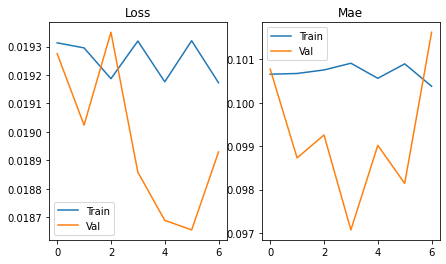

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

plt.sca(ax1)
plt.title('Loss')
plt.plot(history.history['loss'][:-9], label='Train')
plt.plot(history.history['val_loss'][:-9], label='Val')
plt.legend()

plt.sca(ax2)
plt.title('Mae')
plt.plot(history.history['mae'][:-9], label='Train')
plt.plot(history.history['val_mae'][:-9], label='Val')
plt.legend()

# TF Transform

In [ ]:
import tensorflow_transform as tft
def preprocess(inputs):  # inputs is a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

# Tensorflow Datasets

In [ ]:
import tensorflow_datasets as tfds

dataset = tfds.load('mnist')
mnist_train, mnist_test = dataset['train'], dataset['test']

In [57]:
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)

# Tensorflow Hub

In [ ]:
import tensorflow_hub as hub

# Use model
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])

# Or load model and integrate
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", output_shape=[50],
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [64]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.16589954,  0.0254965 ,  0.1574857 ,  0.17688066,  0.02911299,
        -0.03092718,  0.19445257, -0.05709129, -0.08631689, -0.04391516,
         0.13032274,  0.10905275, -0.08515751,  0.01056632, -0.17220995,
        -0.17925954,  0.19556305,  0.0802278 , -0.03247919, -0.49176937,
        -0.07767699, -0.03160921, -0.13952136,  0.05959712,  0.06858718,
         0.22386682, -0.16653948,  0.19412343, -0.05491862,  0.10997339,
        -0.15811177, -0.02576607, -0.07910853, -0.258499  , -0.04206644,
        -0.20052543,  0.1705603 , -0.15314153,  0.0039225 , -0.28694248,
         0.02468278,  0.11069503,  0.03733957,  0.01433943, -0.11048374,
         0.11931834, -0.11552787, -0.11110869,  0.02384969, -0.07074881],
       [ 0.1437864 ,  0.08291595,  0.10897306,  0.04464385, -0.03630389,
        -0.12605834,  0.20263346,  0.12862863, -0.07873426, -0.01195358,
         0.0020956 , -0.03080653, -0.08019945, -0.18797135, -0.11973457,
 

# Exercises

## 1

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [91]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [121]:
from tensorflow.train import Example, Feature, Features, BytesList, Int64List
from contextlib import ExitStack

def create_example(image, label):
    image = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
            'image': Feature(bytes_list=BytesList(value=[image.numpy()])),
            'label': Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

def write_tfrecords(name, dataset, n_shards=10):
    paths = [f'{name}.tfrecord-{index+1}-of-{n_shards}' for index in range(n_shards)]

    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]

        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
        

    return paths


train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)